In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-dataset/Dataset_User_Agreement.pdf
/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json


In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import os
import json
import csv
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import re
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate

In [3]:
# Download latest version
if os.path.exists("/kaggle"):
    path = "/kaggle/input/yelp-dataset"
else:
    path = kagglehub.dataset_download("yelp-dataset/yelp-dataset")
print("Path to dataset files:", path)


def load_data(path, filename, truncate=None):
    data_file = open(os.path.join(path, filename))
    data = []
    if truncate is not None:
        for i, line in enumerate(data_file):
            data.append(json.loads(line))
            if i == truncate:
                break
        # for line in data_file[0:truncate]:
        #     data.append(json.loads(line))
    else:
        for line in data_file:
            data.append(json.loads(line))
    ret_df = pd.DataFrame(data)
    data_file.close()
    return ret_df

businesses_df = load_data(path, "yelp_academic_dataset_business.json")
reviews_df = load_data(path, "yelp_academic_dataset_review.json", truncate=1000000)
tips_df = load_data(path, "yelp_academic_dataset_tip.json")

Path to dataset files: /kaggle/input/yelp-dataset


In [4]:
def filter_business_reviews(df, num_reviews):
    business_and_num_reviews = {}
    for index in df.index:
        business_id = df.loc[index,'business_id']
        if business_id in business_and_num_reviews.keys():
            business_and_num_reviews[business_id] += 1
        else:
            business_and_num_reviews[business_id] = 1
    bus_over_num = []
    for key, value in business_and_num_reviews.items():
        if value >= num_reviews:
            bus_over_num.append(key)
    return df[df['business_id'].isin(bus_over_num)]

reviews_df = filter_business_reviews(reviews_df, 30)

Top 10 categories:  [('Restaurants', 52268), ('Food', 27781), ('Shopping', 24395), ('Home Services', 14356), ('Beauty & Spas', 14292), ('Nightlife', 12281), ('Health & Medical', 11890), ('Local Services', 11198), ('Bars', 11065), ('Automotive', 10773)]


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'Restaurants'),
  Text(1, 0, 'Food'),
  Text(2, 0, 'Shopping'),
  Text(3, 0, 'Home Services'),
  Text(4, 0, 'Beauty & Spas'),
  Text(5, 0, 'Nightlife'),
  Text(6, 0, 'Health & Medical'),
  Text(7, 0, 'Local Services'),
  Text(8, 0, 'Bars'),
  Text(9, 0, 'Automotive'),
  Text(10, 0, 'Event Planning & Services'),
  Text(11, 0, 'Sandwiches'),
  Text(12, 0, 'American (Traditional)'),
  Text(13, 0, 'Active Life'),
  Text(14, 0, 'Pizza'),
  Text(15, 0, 'Coffee & Tea'),
  Text(16, 0, 'Fast Food'),
  Text(17, 0, 'Breakfast & Brunch'),
  Text(18, 0, 'American (New)'),
  Text(19, 0, 'Hotels & Travel'),
  Text(20, 0, 'Home & Garden'),
  Text(21, 0, 'Fashion'),
  Text(22, 0, 'Burgers'),
  Text(23, 0

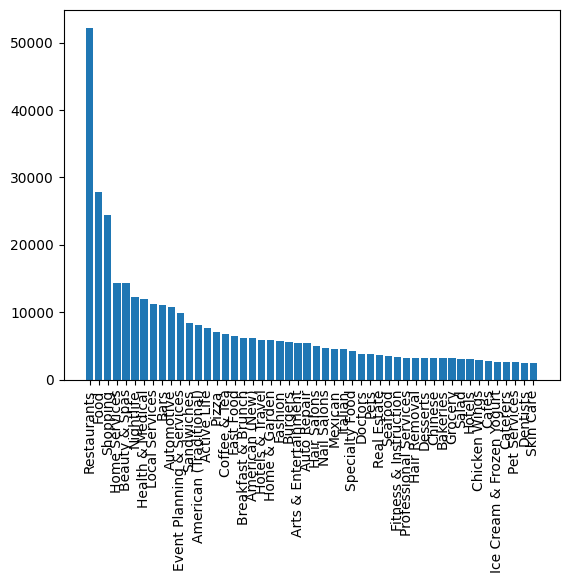

In [5]:
all_unique_cats = {}

for index, row in businesses_df.iterrows():
    if not row['categories']:
        continue
        
    diff_cats = row['categories'].split(", ")
    for cat in diff_cats:
        if cat in all_unique_cats:
            all_unique_cats[cat] += 1
        else:
            all_unique_cats[cat] = 1

sorted_cats = sorted(all_unique_cats.items(), key=lambda x: x[1], reverse=True)
print("Top 10 categories: ", sorted_cats[:10])

num_cats = 50
plt.bar([x[0] for x in sorted_cats[:num_cats]], [x[1] for x in sorted_cats[:num_cats]])
plt.xticks(rotation=90)

In [6]:
reviews_business_df = pd.merge(reviews_df, businesses_df, on="business_id")

In [7]:
import sklearn.preprocessing


want_cats = sorted_cats[:num_cats]

mlb = sklearn.preprocessing.MultiLabelBinarizer(classes=[x[0] for x in want_cats])
y = mlb.fit_transform(reviews_business_df['categories'].str.split(", "))

y.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['ATV Rentals/Tours', 'Acai Bowls', 'Accessories', 'Acupuncture', 'Adult', 'Adult Education', 'Adult Entertainment', 'Aerial Fitness', 'Afghan', 'African', 'Air Duct Cleaning', 'Airlines', 'Airport Lounges', 'Airport Shuttles', 'Airports', 'Amateur Sports Teams', 'Amusement Parks', 'Animal Shelters', 'Antiques', 'Apartments', 'Appliances', 'Appliances & Repair', 'Appraisal Services', 'Aquarium Services', 'Aquariums', 'Arabic', 'Arcades', 'Archery', 'Argentine', 'Armenian', 'Art Classes', 'Art Galleries', 'Art Museums', 'Art Schools', 'Art Space Rentals', 'Art Supplies', 'Art Tours', 'Arts & Crafts', 'Asian Fusion', 'Astrologers', 'Auction Houses', 'Audiologist', 'Australian', 'Austrian', 'Auto Customization', 'Auto Detailing', 'Auto Glass Services', 'Auto Loan Providers', 'Auto Parts & Supplies', 'Auto Security', 'Axe Throwing', 'Baby Gear & Furniture', 'Bagels', 'Banks & Credit 

(803415, 50)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# 1. Create a Dataset class that tokenizes the texts and returns the labels
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        Args:
            texts (list of str): List of input text strings.
            labels (list of list/int): 2D array (list of lists) of binary labels.
            tokenizer: Pre-trained BERT tokenizer.
            max_length (int): Maximum token length for each input.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        
        # Tokenize the text with the BERT tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',  # pad to max_length
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),           # tensor of shape (max_length)
            'attention_mask': encoding['attention_mask'].squeeze(0),     # tensor of shape (max_length)
            'labels': torch.tensor(label, dtype=torch.float)           # multi-label target vector
        }

# 2. Create a model class that uses BERT with an added classification head.
class BertForMultiLabelClassification(nn.Module):
    def __init__(self, n_labels, pretrained_model_name='bert-base-uncased'):
        """
        Args:
            n_labels (int): Number of labels (i.e. the size of the binary vector).
            pretrained_model_name (str): Name of the pre-trained BERT model.
        """
        super(BertForMultiLabelClassification, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_labels)
        
    def forward(self, input_ids, attention_mask):
        # Forward pass through BERT.
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use the pooled output [CLS] representation for classification.
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)  # shape: (batch_size, n_labels)
        return logits

# 3. Define a training function.
def train_epoch(model, data_loader, optimizer, loss_fn, device, scheduler=None):
    model.train()
    total_loss = 0

    for batch in data_loader:
        # Move batch data to the device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Get raw logits from the model
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Compute the loss using BCEWithLogitsLoss (which applies a sigmoid internally)
        loss = loss_fn(logits, labels)
        total_loss += loss.item()
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
            
    return total_loss / len(data_loader)

# 4. Main function tying everything together.
def main():
    # Example data: an array of texts and a 2D array of labels.
    
    # texts = [
    #     "I love programming in Python!",
    #     "The movie was a total waste of time.",
    #     "The food was delicious and the service was excellent.",
    #     "I did not enjoy the play at all."
    # ]
    texts = reviews_business_df["text"]
    
    # For example, suppose we have 3 labels: [Positive, Negative, Neutral]
    # Each example can have more than one label marked as 1.
    
    # labels = [
    #     [1, 0, 0],  # Positive sentiment
    #     [0, 1, 0],  # Negative sentiment
    #     [1, 0, 0],  # Positive sentiment
    #     [0, 1, 1]   # Negative and Neutral (for illustration)
    # ]
    labels = y
    
    n_labels = len(mlb.classes)
    
    # Initialize the tokenizer.
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Create the dataset and dataloader.
    dataset = MultiLabelDataset(texts, labels, tokenizer, max_length=64)
    data_loader = DataLoader(dataset, batch_size=2, shuffle=True)
    
    # Setup the device.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize the model.
    model = BertForMultiLabelClassification(n_labels=n_labels)
    model = model.to(device)
    
    # Define optimizer and scheduler.
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    total_steps = len(data_loader) * 3  # e.g., 3 epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    
    # Loss function for multi-label classification.
    loss_fn = nn.BCEWithLogitsLoss().to(device)
    
    # Training loop.
    epochs = 1
    for epoch in range(epochs):
        avg_loss = train_epoch(model, data_loader, optimizer, loss_fn, device, scheduler)
        print(f"Epoch {epoch+1}/{epochs} - Average Training Loss: {avg_loss:.4f}")
    
    # (Optional) Save the trained model.
    torch.save(model.state_dict(), "bert_multi_label_classifier.pth")
    print("Training complete and model saved.")

if __name__ == '__main__':
    main()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
import torch

def predict(model, tokenizer, texts, max_length=64, threshold=0.5, device=torch.device("cpu")):
    """
    Predicts multi-label outputs for a list of text inputs.

    Args:
        model: The trained BERT multi-label classifier.
        tokenizer: The pre-trained BERT tokenizer.
        texts (list of str): List of input text strings.
        max_length (int): Maximum sequence length for tokenization.
        threshold (float): Threshold for deciding whether a label is active.
        device: The device on which to perform computation (CPU or GPU).

    Returns:
        List of predicted label lists.
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():
        for text in texts:
            # Tokenize the input text
            encoding = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_length,
                truncation=True,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt'
            )

            # Move tensors to the appropriate device
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            # Forward pass through the model
            logits = model(input_ids=input_ids, attention_mask=attention_mask)

            # Apply sigmoid to convert logits to probabilities
            probs = torch.sigmoid(logits)

            # Convert probabilities to binary predictions based on the threshold
            pred_labels = (probs > threshold).int().squeeze(0).tolist()
            predictions.append(pred_labels)

    return predictions

# Example usage:
if __name__ == '__main__':
    # Assume that the model has been trained and is available,
    # and that the tokenizer is the same one used during training.
    from transformers import BertTokenizer

    # Setup device (use GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the tokenizer and model.
    # Make sure to use the same pre-trained model name and number of labels as before.
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    n_labels = y.shape[1]  # Example: 3 labels as in our training example

    # Instantiate the model and load its state if saved.
    model = BertForMultiLabelClassification(n_labels=n_labels)
    model.load_state_dict(torch.load("bert_multi_label_classifier.pth", map_location=device))
    model = model.to(device)

    # New texts for which to predict labels.
    new_texts = []

    # Get predictions for the new texts.
    predictions = predict(model, tokenizer, new_texts, max_length=64, threshold=0.5, device=device)

    # Print out the predictions.
    for text, pred in zip(new_texts, predictions):
        print(f"Text: {text}")
        print(f"Predicted Labels: {pred}\n")
        print(f"Predicted transform labels: {mlb.inverse_transform(np.array(pred).reshape(1, -1))}")
